In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error


In [2]:
class WaveformDataset(Dataset):
    def __init__(self, waves_path, vels_path):
        self.waves = np.load(waves_path)
        self.vels  = np.load(vels_path)
    def __len__(self):
        return len(self.waves)
    def __getitem__(self, idx):
        x = torch.from_numpy(self.waves[idx]).float()
        y = torch.from_numpy(self.vels[idx]).float()
        return x, y

train_ds = WaveformDataset("../dataset_one_batch/train_waves.npy", "../dataset_one_batch/train_vels.npy")
val_ds   = WaveformDataset("../dataset_one_batch/val_waves.npy", "../dataset_one_batch/val_vels.npy")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)


In [3]:
class WaveformEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(3, 5, 3), padding=(1, 2, 1))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool3d((1, 10, 10))
        self.fc = nn.Linear(32 * 10 * 10, 1024)
        self.out = nn.Linear(1024, 70 * 70)
        torch.nn.init.constant_(self.out.bias, 2500)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = F.relu(self.out(x))
        return x.view(-1, 1, 70, 70)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WaveformEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 20
model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader.dataset):.4f}")


Epoch 1: Loss = 465318.3868
Epoch 2: Loss = 369176.1137
Epoch 3: Loss = 339628.1609
Epoch 4: Loss = 314444.2014
Epoch 5: Loss = 295135.2556
Epoch 6: Loss = 285564.3903
Epoch 7: Loss = 278114.7088
Epoch 8: Loss = 268595.8149
Epoch 9: Loss = 266171.3770
Epoch 10: Loss = 257947.9058
Epoch 11: Loss = 254380.4684
Epoch 12: Loss = 251813.5843
Epoch 13: Loss = 249915.9822
Epoch 14: Loss = 242888.9598
Epoch 15: Loss = 240326.7002
Epoch 16: Loss = 234636.7498
Epoch 17: Loss = 233109.5739
Epoch 18: Loss = 227842.4661
Epoch 19: Loss = 226300.2757
Epoch 20: Loss = 221499.1903


In [5]:
model.eval()
mae_list = []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        targets = yb.numpy()
        mae = np.abs(preds - targets).mean()
        mae_list.append(mae)

print(f"Mean Absolute Error on validation set: {np.mean(mae_list):.2f} m/s")


Mean Absolute Error on validation set: 363.55 m/s


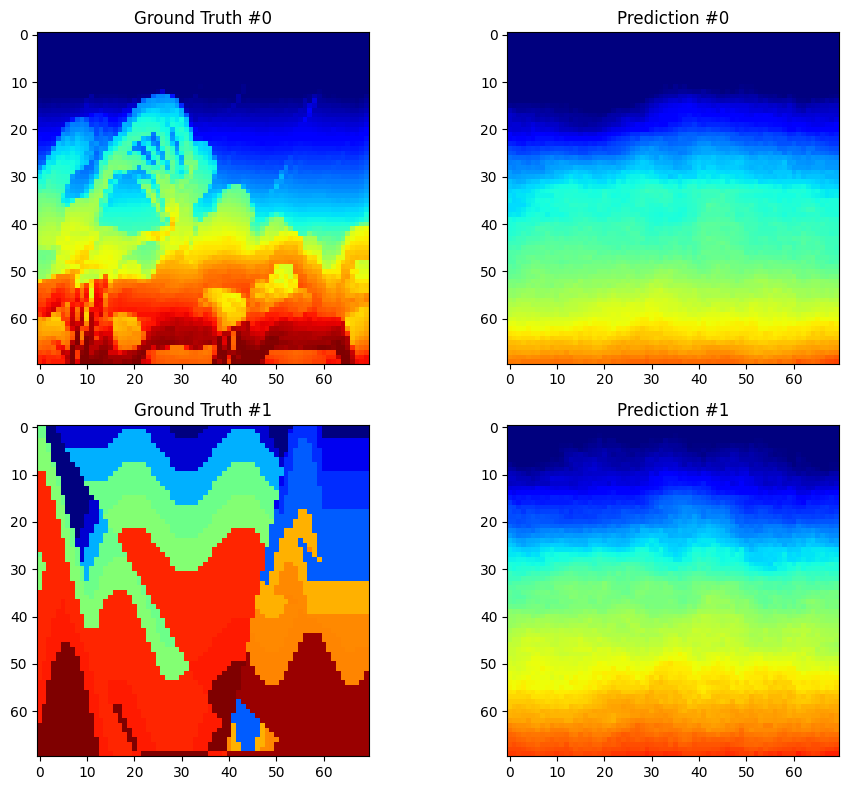

In [6]:
xb, yb = next(iter(val_loader))
xb = xb.to(device)
with torch.no_grad():
    v_pred = model(xb).cpu()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for i in range(2):
    axes[i, 0].imshow(yb[i, 0], cmap="jet", vmin=2000, vmax=4000)
    axes[i, 0].set_title(f"Ground Truth #{i}")
    axes[i, 1].imshow(v_pred[i, 0], cmap="jet", vmin=2000, vmax=4000)
    axes[i, 1].set_title(f"Prediction #{i}")
plt.tight_layout()
plt.show()
